# Non-Gourmet Artificial Neural Network

In [0]:
# unzip files
import zipfile
zip_ref = zipfile.ZipFile('files.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [0]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

## Theo's pre-processed image data

In [0]:
theoPreprocessedPath = 'processedData.npy'
theo_rawImgMats = np.load(theoPreprocessedPath)

In [0]:
theoProcessed_ImgSet = np.empty((len(theo_rawImgMats),40,40))

for idx in range(len(theo_rawImgMats)):
    theoProcessed_ImgSet[idx,:,:] = theo_rawImgMats[idx].reshape((40,40))
    
print(np.shape(theoProcessed_ImgSet))

(10000, 40, 40)


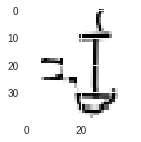

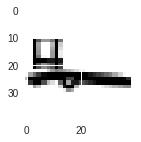

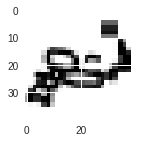

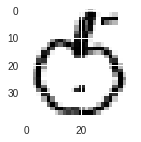

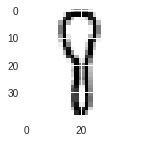

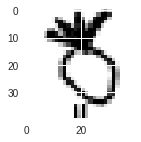

In [0]:
for idx in range(len(theoProcessed_ImgSet)):
    if idx > 5:
        break
    
    # SHow image
    plt.figure(figsize=(2,2))
    plt.imshow(theoProcessed_ImgSet[idx], cmap='gray_r')
    plt.show()

### Flatten images

In [0]:
# Array to store this
X_unscaled = np.empty((np.shape(theoProcessed_ImgSet)[0],
                       np.shape(theoProcessed_ImgSet)[1] * np.shape(theoProcessed_ImgSet)[2]))

# Flatten images
for i, imgMat in enumerate(theoProcessed_ImgSet):
    X_unscaled[i, :] = imgMat.flatten()

np.shape(X_unscaled)

(10000, 1600)

## Clean-up for model

### Get labels

In [0]:
TRAIN_LAB_PATH = "train_labels.csv"

lab_df = pd.read_csv(TRAIN_LAB_PATH)
print(len(lab_df))
lab_df[0:3]

10000


,Id,Category
0,0,shovel
1,1,rifle
2,2,scorpion


In [0]:
# Get labels and encode
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# Get data
string_labels = lab_df['Category'].values
# Integer encode
le = LabelEncoder()
y_intLab = le.fit_transform(string_labels)
# One hot encode
encoder_OH = OneHotEncoder(sparse=False)
y_intLab = y_intLab.reshape(len(y_intLab), 1)
y_preShuf = encoder_OH.fit_transform(y_intLab)

### Scale 

In [0]:
# SCale
X_preShuf = X_unscaled / np.max(X_unscaled)
print(np.shape(X_preShuf))

(10000, 1600)


### Shuffle data and split

In [0]:
# Whether or not to use a random subset of data
USE_SUBSET = False
SUBSET_NUM = 4000


# Shuffle
from sklearn.utils import shuffle
X, y = shuffle(X_preShuf, y_preShuf, random_state=42)


if USE_SUBSET:
  X = X[0:SUBSET_NUM, :]
  y = y[0:SUBSET_NUM, :]

print(np.shape(X))
print(np.shape(y))


(10000, 1600)
(10000, 31)


In [0]:
# Split into sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size=0.20, random_state=42)

print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(8000, 1600)
(2000, 1600)
(8000, 31)
(2000, 31)


## Importing home-made ANN 

In [0]:
import homecooked_NN as hHH

model = hHH.sequential_model(alpha=0.01)

model.input_layer(1600)
model.add_hidden(128, activation='sigmoid')
#model.add_hidden(64, activation='relu')
model.output_layer(31, activation='softmax')

model.summarize()


Index 0:	(1601, 1) --- (1601, 128) --->
Index 1:	(129, 1) --- (129, 31) --->
Output layer: 	(31, 1)


In [0]:
EPOCHS = 8
trainingMetrics = model.train(X_train, y_train,
                              epochs=EPOCHS,
                              validation=(X_test, y_test)
                             )

Epoch 1/8	| loss: 0.007596	| acc: 0.657125	| val_loss: 0.012089	| val_acc: 0.420500	| 
Epoch 2/8	| loss: 0.007541	| acc: 0.660000	| val_loss: 0.012096	| val_acc: 0.419500	| 
Epoch 3/8	| loss: 0.007486	| acc: 0.662250	| val_loss: 0.012105	| val_acc: 0.419500	| 
Epoch 4/8	| loss: 0.007432	| acc: 0.666375	| val_loss: 0.012113	| val_acc: 0.419000	| 
Epoch 5/8	| loss: 0.007379	| acc: 0.669500	| val_loss: 0.012121	| val_acc: 0.418500	| 
Epoch 6/8	| loss: 0.007327	| acc: 0.672000	| val_loss: 0.012129	| val_acc: 0.416500	| 
Epoch 7/8	| loss: 0.007274	| acc: 0.675250	| val_loss: 0.012138	| val_acc: 0.416000	| 
Epoch 8/8	| loss: 0.007223	| acc: 0.678125	| val_loss: 0.012147	| val_acc: 0.415000	| 


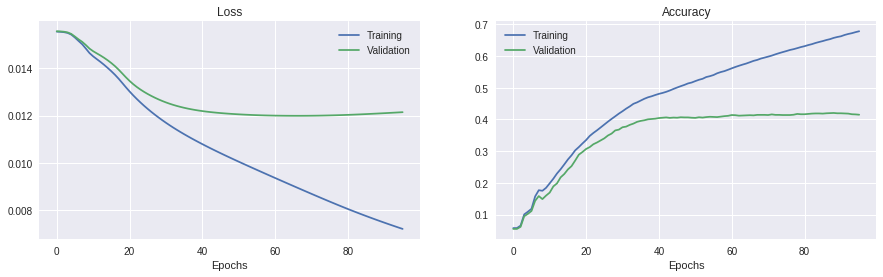

In [0]:
# Visualize the loss
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(trainingMetrics['loss'])
plt.plot(trainingMetrics['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(trainingMetrics['acc'])
plt.plot(trainingMetrics['val_acc'])
plt.legend(['Training','Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [0]:
# Save weights
import pickle

SAVE_MODEL = True
OUT_PATH = 'model_128_sigmoid_allData.pickle'

if SAVE_MODEL:
  with open(OUT_PATH, 'wb') as handle:
    pickle.dump(model, handle)


# New Section